In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3

In [3]:

conn = sqlite3.connect('../data_storage/spotify.db')

query = '''
    SELECT ar1.artist_name AS artist1,
           ar2.artist_name AS artist2,
           COUNT(DISTINCT pt1.pid) AS num_playlists_together,
           ROUND(CAST(COUNT(DISTINCT pt1.pid) AS FLOAT) / (
               SELECT COUNT(DISTINCT pid) FROM playlist WHERE pid IN (
                   SELECT pid FROM playlist ORDER BY pid LIMIT 100
               )
           ) * 100, 2) AS percentage_together
    FROM playlist_track pt1
    JOIN playlist_track pt2 ON pt1.pid = pt2.pid AND pt1.track_uri <> pt2.track_uri
    JOIN track t1 ON pt1.track_uri = t1.track_uri
    JOIN track t2 ON pt2.track_uri = t2.track_uri
    JOIN album a1 ON t1.album_uri = a1.album_uri
    JOIN album a2 ON t2.album_uri = a2.album_uri
    JOIN artist ar1 ON a1.artist_uri = ar1.artist_uri
    JOIN artist ar2 ON a2.artist_uri = ar2.artist_uri AND ar1.artist_uri <> ar2.artist_uri
    WHERE pt1.pid IN (SELECT pid FROM playlist ORDER BY pid LIMIT 100)  -- Limit to first 100 playlists
    GROUP BY artist1, artist2
    ORDER BY num_playlists_together DESC
'''

df = pd.read_sql_query(query, conn)

conn.close()

print("Top Artist Co-occurrences in Playlists with Percentage:")
print(df.head(10)) 


Top Artist Co-occurrences in Playlists with Percentage:
            artist1           artist2  num_playlists_together  \
0        Ed Sheeran           Rihanna                      11   
1           Rihanna        Ed Sheeran                      11   
2             Drake        Kanye West                      10   
3        Kanye West             Drake                      10   
4        Ed Sheeran  The Chainsmokers                       9   
5  The Chainsmokers        Ed Sheeran                       9   
6        Ed Sheeran      Jason Derulo                       8   
7      Jason Derulo        Ed Sheeran                       8   
8      Alessia Cara  The Chainsmokers                       7   
9     Ariana Grande        Ed Sheeran                       7   

   percentage_together  
0                 11.0  
1                 11.0  
2                 10.0  
3                 10.0  
4                  9.0  
5                  9.0  
6                  8.0  
7                  8.0  
8  

In [4]:
print(df.tail(100))

              artist1          artist2  num_playlists_together  \
174909      will.i.am    Ty Dolla $ign                       1   
174910      will.i.am             Tyga                       1   
174911      will.i.am    William Singe                       1   
174912      will.i.am         Yo Gotti                       1   
174913      will.i.am       Young Thug                       1   
...               ...              ...                     ...   
175004  ✝✝✝ (Crosses)          Whitney                       1   
175005  ✝✝✝ (Crosses)  Young the Giant                       1   
175006  ✝✝✝ (Crosses)        Zella Day                       1   
175007  ✝✝✝ (Crosses)            alt-J                       1   
175008  ✝✝✝ (Crosses)        blink-182                       1   

        percentage_together  
174909                  1.0  
174910                  1.0  
174911                  1.0  
174912                  1.0  
174913                  1.0  
...                     ...

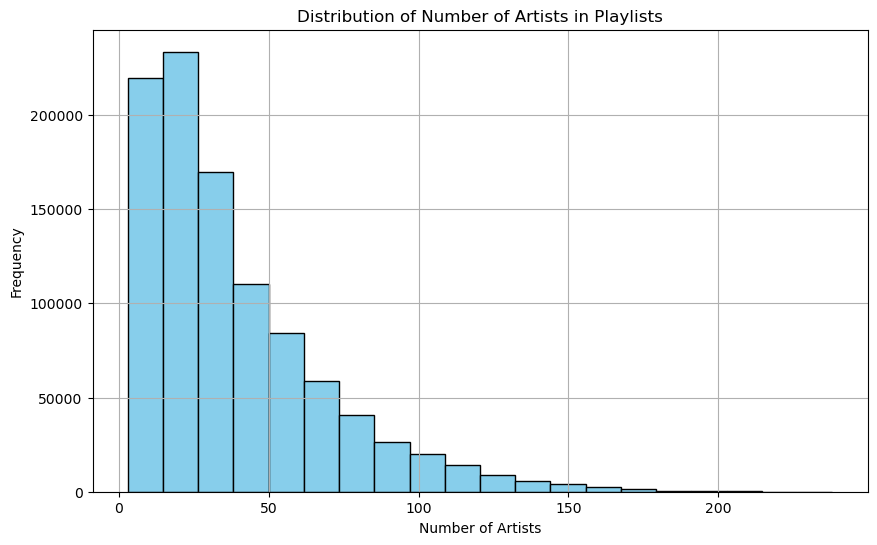

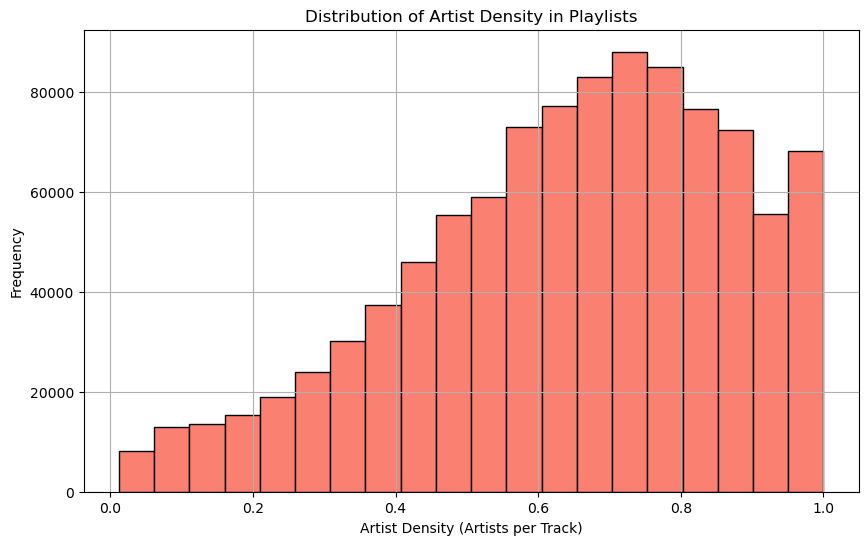

In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('../data_storage/spotify.db')

# SQL query to retrieve playlist data (number of artists and total tracks)
query = '''
    SELECT pid, num_artists, num_tracks
    FROM playlist
    WHERE pid IN (SELECT pid FROM playlist ORDER BY pid LIMIT 1000000)  -- Limit to first 10,000 playlists
'''

# Execute the SQL query and load results into a DataFrame
playlist_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Calculate artist density (artists per track) for each playlist
playlist_data['artist_density'] = playlist_data['num_artists'] / playlist_data['num_tracks']

# Plotting the distribution of number of artists per playlist
plt.figure(figsize=(10, 6))
plt.hist(playlist_data['num_artists'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Artists in Playlists')
plt.xlabel('Number of Artists')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting the distribution of artist density in playlists
plt.figure(figsize=(10, 6))
plt.hist(playlist_data['artist_density'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Artist Density in Playlists')
plt.xlabel('Artist Density (Artists per Track)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


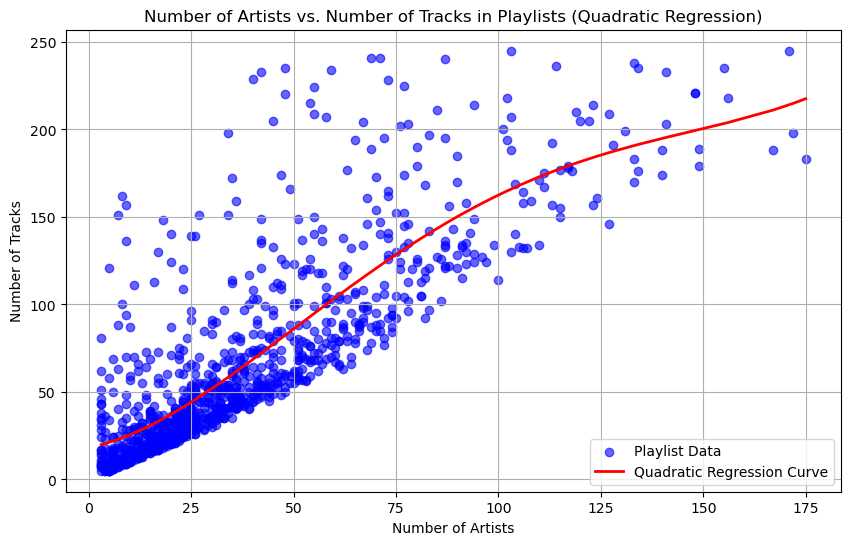

Quadratic Regression Model: y = 0.03x^2 + 0.46x + 18.27


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Connect to the SQLite database
conn = sqlite3.connect('../data_storage/spotify.db')

# SQL query to retrieve playlist data (number of artists and total tracks)
query = '''
    SELECT pid, num_artists, num_tracks
    FROM playlist
    WHERE pid IN (SELECT pid FROM playlist ORDER BY pid LIMIT 1000)  -- Limit to first 10,000 playlists
'''

# Execute the SQL query and load results into a DataFrame
playlist_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

X = playlist_data[['num_artists']].values  
y = playlist_data['num_tracks'].values    

poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

X_sorted = np.sort(X, axis=0)
X_sorted_poly = poly_features.transform(X_sorted)

y_pred = model.predict(X_sorted_poly)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label='Playlist Data')  
plt.plot(X_sorted, y_pred, color='red', linewidth=2, label='Quadratic Regression Curve')  
plt.title('Number of Artists vs. Number of Tracks in Playlists (Quadratic Regression)')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Tracks')
plt.legend()
plt.grid(True)
plt.show()

coefficients = model.coef_
intercept = model.intercept_
print(f'Quadratic Regression Model: y = {coefficients[2]:.2f}x^2 + {coefficients[1]:.2f}x + {intercept:.2f}')

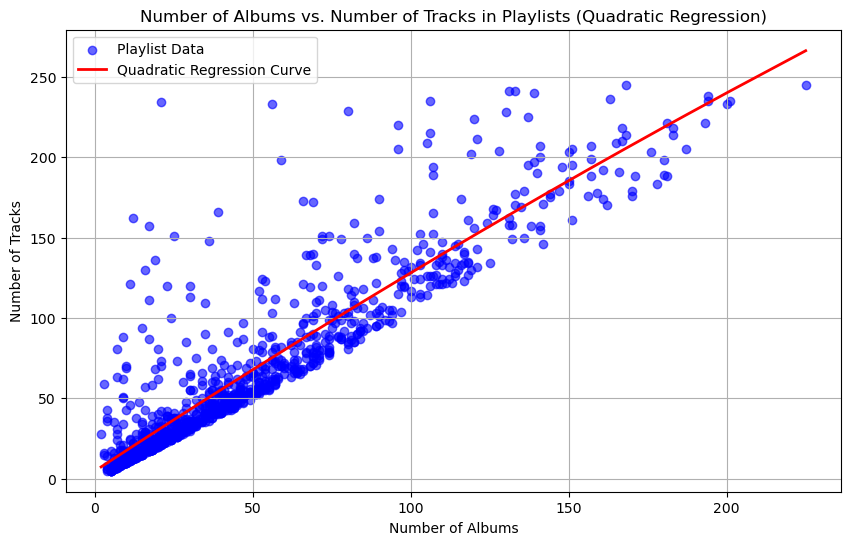

Quadratic Regression Model: y = -0.00x^2 + 1.29x + 4.80


In [7]:

conn = sqlite3.connect('../data_storage/spotify.db')

query = '''
    SELECT num_albums, num_tracks
    FROM playlist
    WHERE pid IN (SELECT pid FROM playlist ORDER BY pid LIMIT 1000)  -- Limit to first 10,000 playlists
'''

playlist_data = pd.read_sql_query(query, conn)

conn.close()
X = playlist_data[['num_albums']].values  
y = playlist_data['num_tracks'].values    

poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

X_sorted = np.sort(X, axis=0)
X_sorted_poly = poly_features.transform(X_sorted)

y_pred = model.predict(X_sorted_poly)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label='Playlist Data')  
plt.plot(X_sorted, y_pred, color='red', linewidth=2, label='Quadratic Regression Curve')  
plt.title('Number of Albums vs. Number of Tracks in Playlists (Quadratic Regression)')
plt.xlabel('Number of Albums')
plt.ylabel('Number of Tracks')
plt.legend()
plt.grid(True)
plt.show()

coefficients = model.coef_
intercept = model.intercept_
print(f'Quadratic Regression Model: y = {coefficients[2]:.2f}x^2 + {coefficients[1]:.2f}x + {intercept:.2f}')


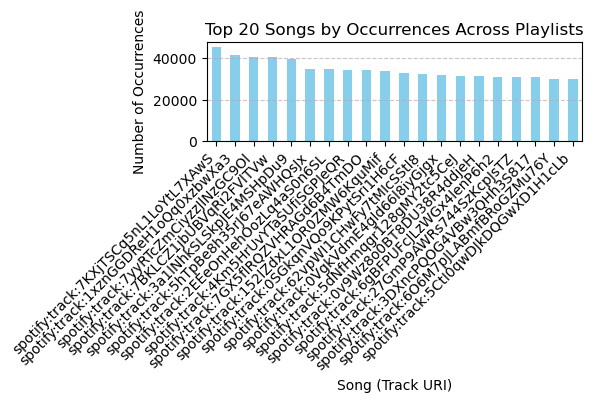

In [8]:

conn = sqlite3.connect('../data_storage/spotify.db')

query = '''
    SELECT track_uri
    FROM playlist_track
'''
playlist_tracks = pd.read_sql_query(query, conn)

conn.close()

song_occurrences = playlist_tracks['track_uri'].value_counts()

plt.figure(figsize=(6, 4))
song_occurrences.head(20).plot(kind='bar', color='skyblue')  
plt.title('Top 20 Songs by Occurrences Across Playlists')
plt.xlabel('Song (Track URI)')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

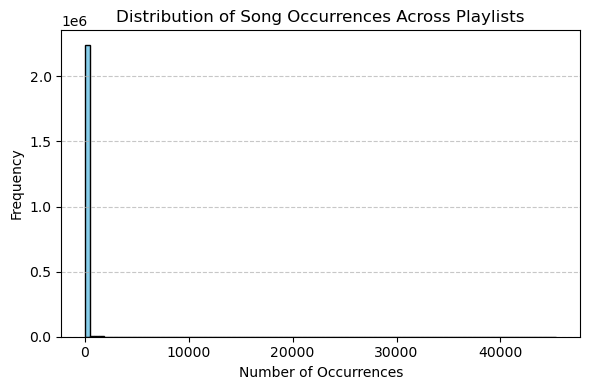

In [9]:
# Plotting the histogram for song occurrences
plt.figure(figsize=(6, 4))
plt.hist(song_occurrences, bins=100, color='skyblue', edgecolor='black')  # Plot histogram with 30 bins
plt.title('Distribution of Song Occurrences Across Playlists')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

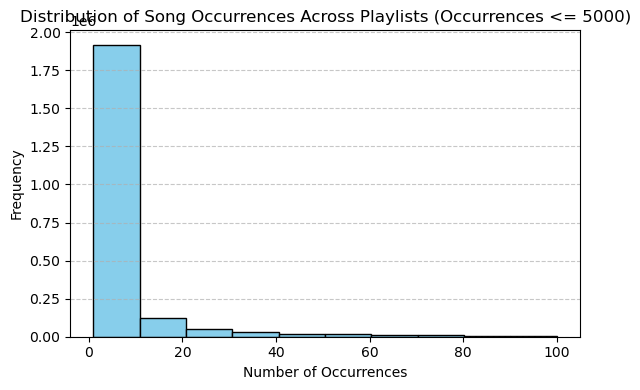

In [10]:
filtered_song_occurrences = song_occurrences[song_occurrences <= 100]

# Plotting the histogram for filtered song occurrences
plt.figure(figsize=(6, 4))
plt.hist(filtered_song_occurrences, bins=10, color='skyblue', edgecolor='black')  # Plot histogram with 30 bins
plt.title('Distribution of Song Occurrences Across Playlists (Occurrences <= 5000)')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

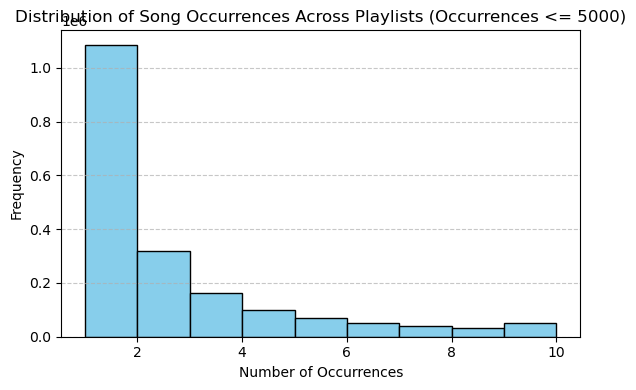

In [11]:
filtered_song_occurrences = song_occurrences[song_occurrences <= 10]

# Plotting the histogram for filtered song occurrences
plt.figure(figsize=(6, 4))
plt.hist(filtered_song_occurrences, bins=9, color='skyblue', edgecolor='black')  # Plot histogram with 30 bins
plt.title('Distribution of Song Occurrences Across Playlists (Occurrences <= 5000)')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

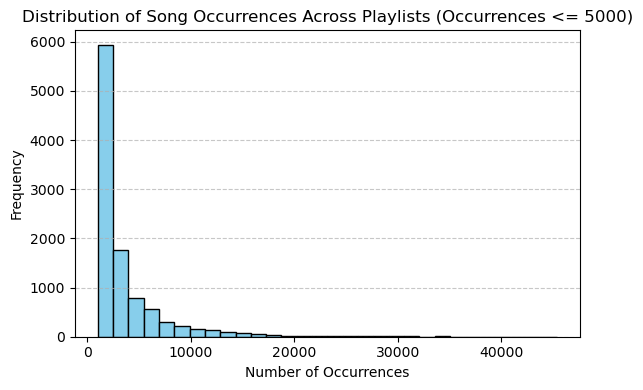

In [12]:
filtered_song_occurrences = song_occurrences[1000 < song_occurrences]

# Plotting the histogram for filtered song occurrences
plt.figure(figsize=(6, 4))
plt.hist(filtered_song_occurrences, bins=30, color='skyblue', edgecolor='black')  # Plot histogram with 30 bins
plt.title('Distribution of Song Occurrences Across Playlists (Occurrences <= 5000)')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

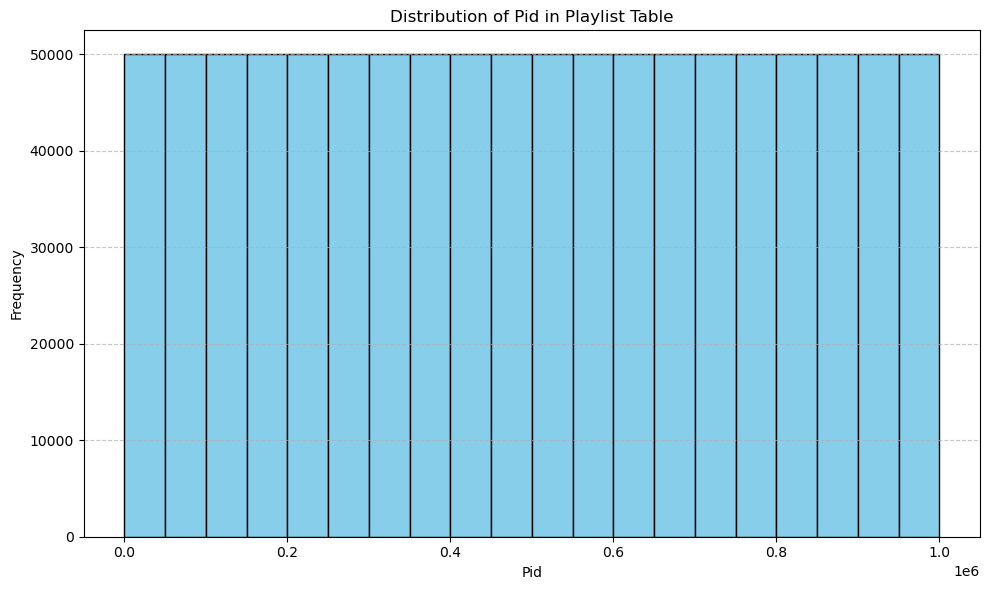

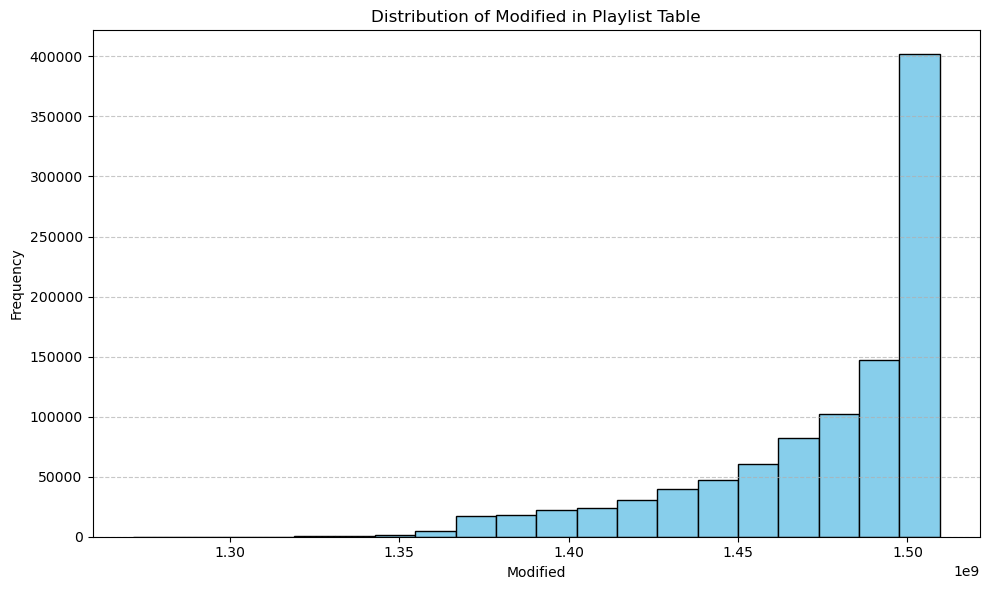

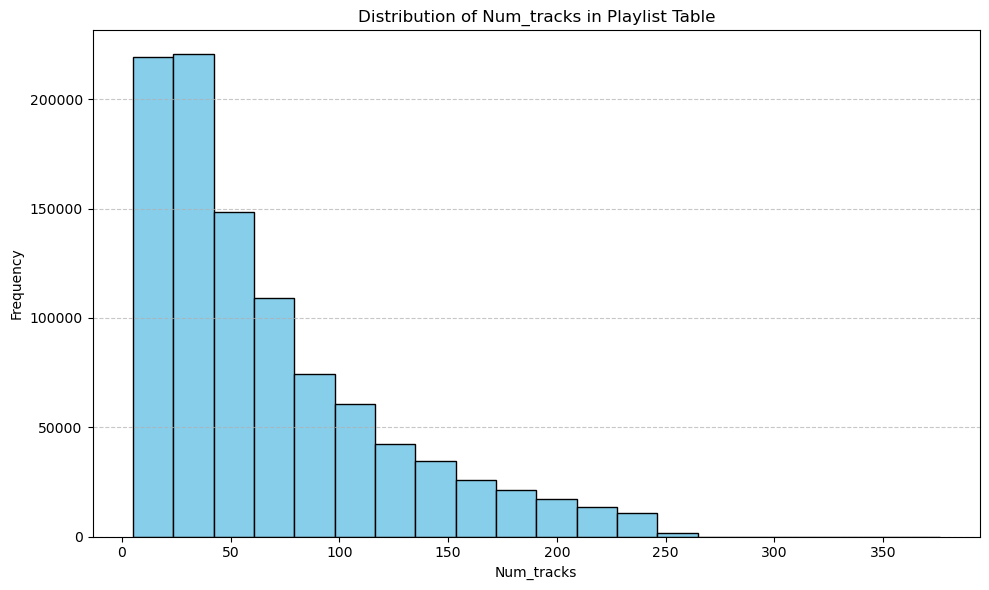

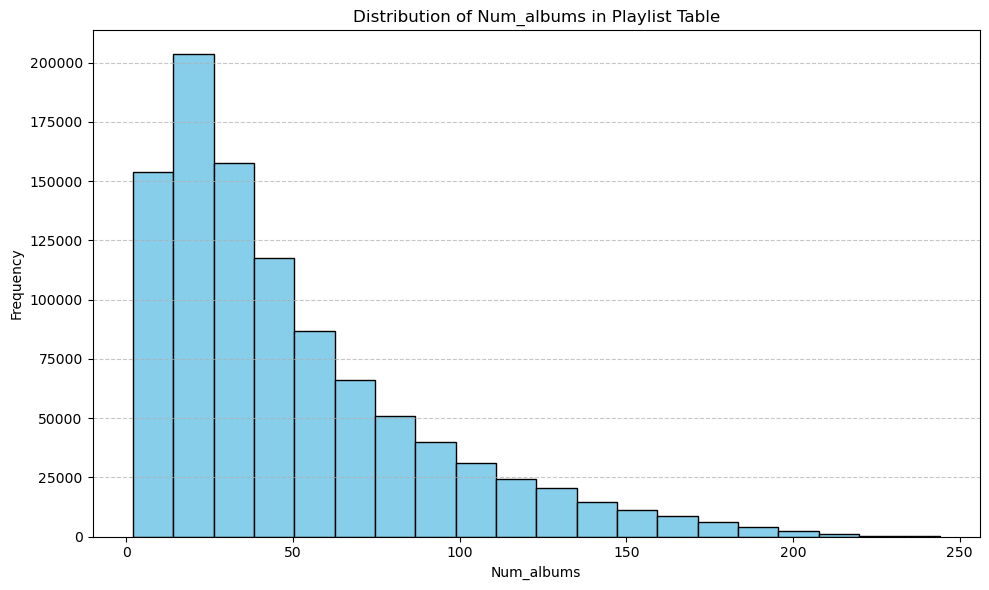

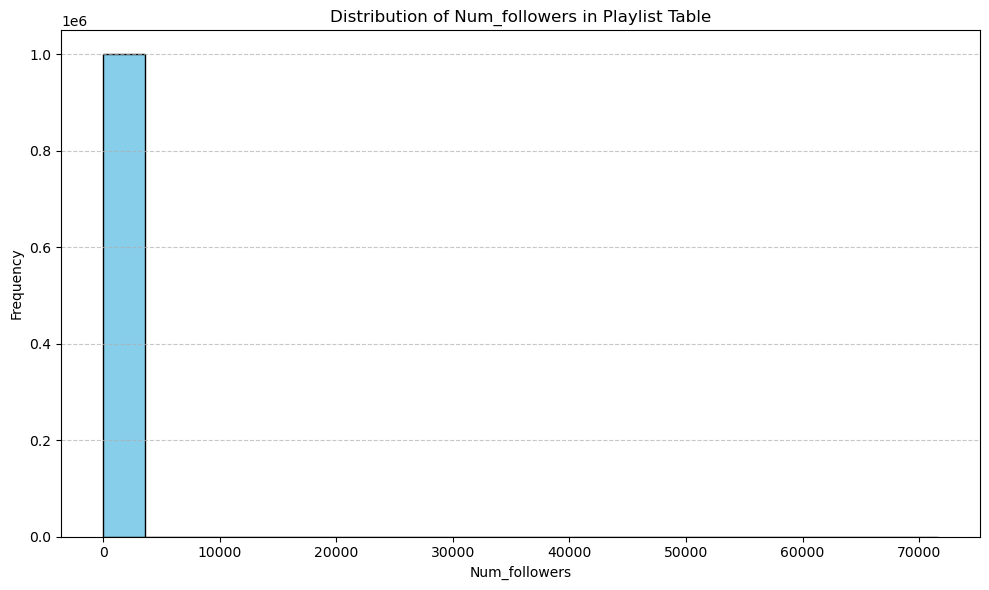

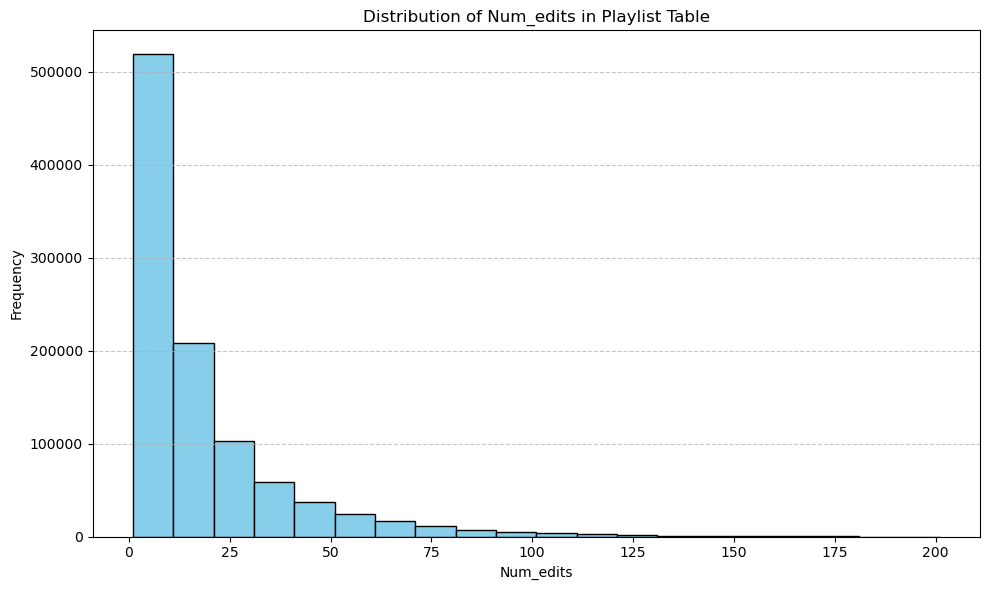

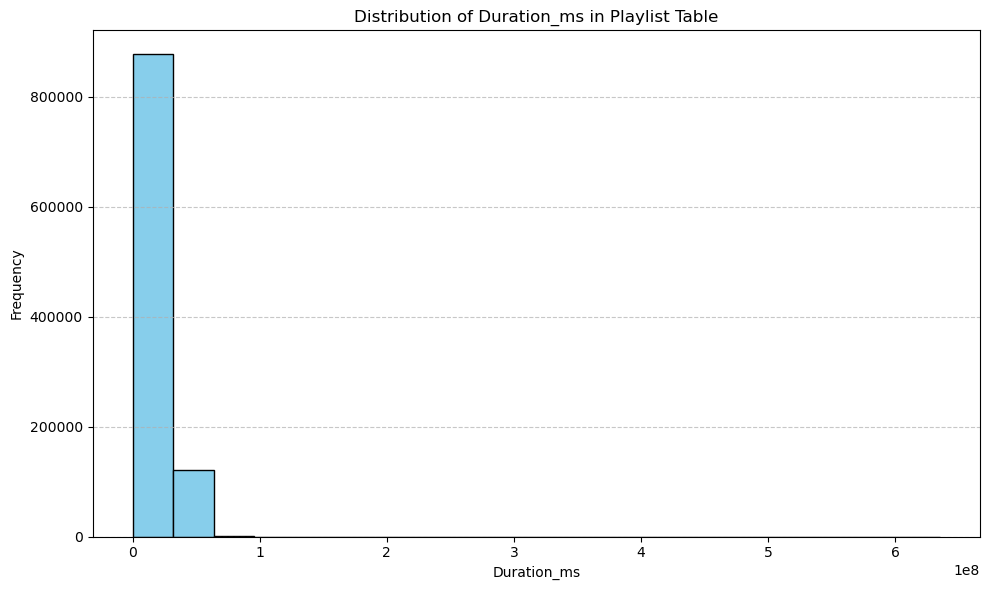

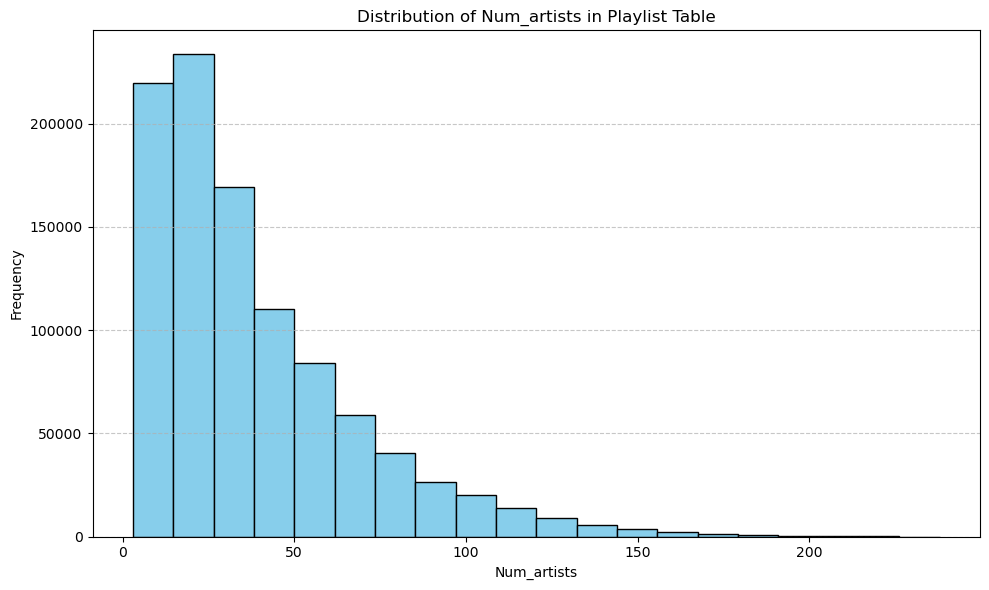

In [13]:

conn = sqlite3.connect('../data_storage/spotify.db')

integer_columns = ['pid', 'modified', 'num_tracks', 'num_albums', 'num_followers', 'num_edits', 'duration_ms', 'num_artists']

for column in integer_columns:
    query = f'''
        SELECT {column}
        FROM playlist
    '''
    
    df = pd.read_sql_query(query, conn)
    
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')  # Plot histogram with 20 bins
    plt.title(f'Distribution of {column.capitalize()} in Playlist Table')
    plt.xlabel(f'{column.capitalize()}')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Close the database connection
conn.close()
